# AI & Basic Data Science assignment
# Machine learning forecasting using regression (SARIMAX)
# Task: To predict the Indonesian stock market at the first part of 2023: bullish or bear?

In [1]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)
simplefilter(action='ignore', category=UserWarning)

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import itertools

In [4]:
# taking data from yahoo finance
import yfinance as yf
# training data
symbol = '^JKSE' # Indonesia Stock Index
dl_start="2016-01-01"
dl_end = "2022-12-30" # end. we will forecast 2023 first six months
df = yf.download(symbol,start=dl_start, end=dl_end)

[*********************100%%**********************]  1 of 1 completed


In [5]:
# I will use Adj Close instead of Close. Adj Close incorporated dividen & other corporate actions
df['Close'] = df['Adj Close']
drop_cols = ['Volume', 'Open', 'Low', 'High', 'Adj Close']
df = df.drop(drop_cols,axis=1)

In [6]:
df.isnull().values.any()

False

In [7]:

df.isna().values.any()

False

In [8]:
df.index.min(), df.index.max()

(Timestamp('2016-01-04 00:00:00'), Timestamp('2022-12-29 00:00:00'))

In [9]:
df.index

DatetimeIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08', '2016-01-11', '2016-01-12', '2016-01-13',
               '2016-01-14', '2016-01-15',
               ...
               '2022-12-16', '2022-12-19', '2022-12-20', '2022-12-21',
               '2022-12-22', '2022-12-23', '2022-12-26', '2022-12-27',
               '2022-12-28', '2022-12-29'],
              dtype='datetime64[ns]', name='Date', length=1704, freq=None)

In [10]:
# We will be using the averages daily closing price for each month to forecast
# The start of each month as the timestamp
y = df['Close'].resample('MS').mean()


In [11]:
y.shape

(84,)

There are 72 months of data

In [12]:
y.isna().values.any()

False

In [13]:
# Have a quick peek the closing price since 2017
y['2017':]

Date
2017-01-01    5294.857422
2017-02-01    5370.014880
2017-03-01    5478.665261
2017-04-01    5649.746180
2017-05-01    5692.100830
                 ...     
2022-08-01    7115.565629
2022-09-01    7188.818204
2022-10-01    6986.436709
2022-11-01    7046.161266
2022-12-01    6839.629604
Freq: MS, Name: Close, Length: 72, dtype: float64

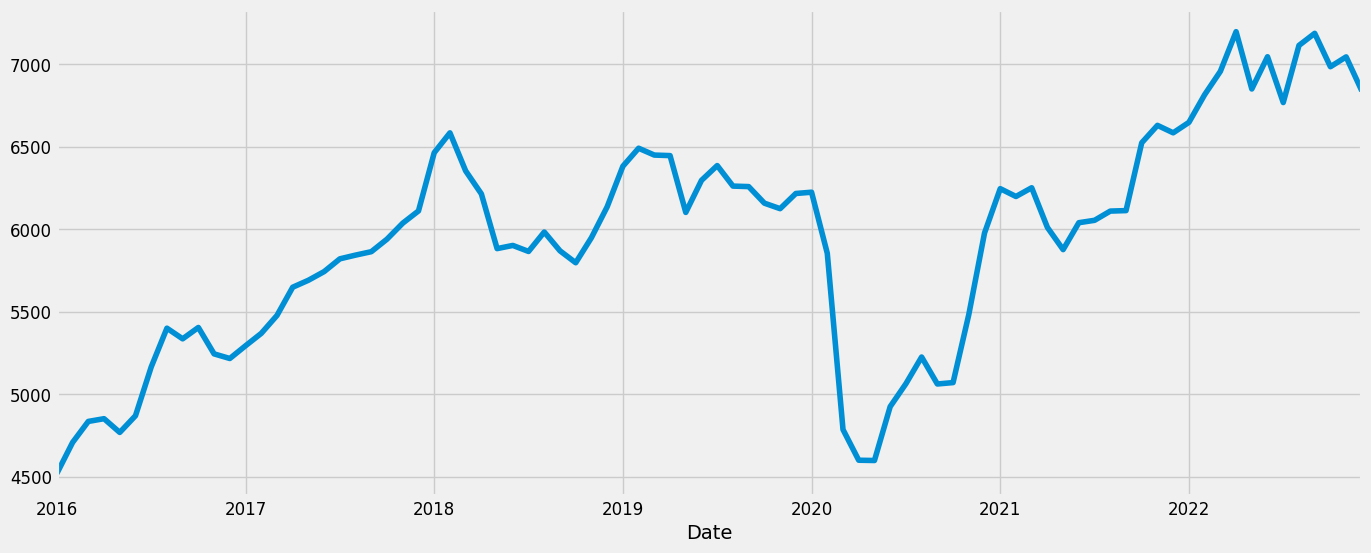

In [14]:
# Visualizing the close price
y.plot(figsize=(15, 6))
plt.show()

Observation:
1) The stock price from 2018 to 2020 sideways in range 5500 - 6500 after trending up in 2017
2) There were huge dips in the stock prices in March 2020(due to Pandemic).
3) The stock prices increased from 2020 (after new normal) to early 2023
4) The stock price was sideways from mid 2022 to end 2022
So, what will happen in 2023 semester 1?

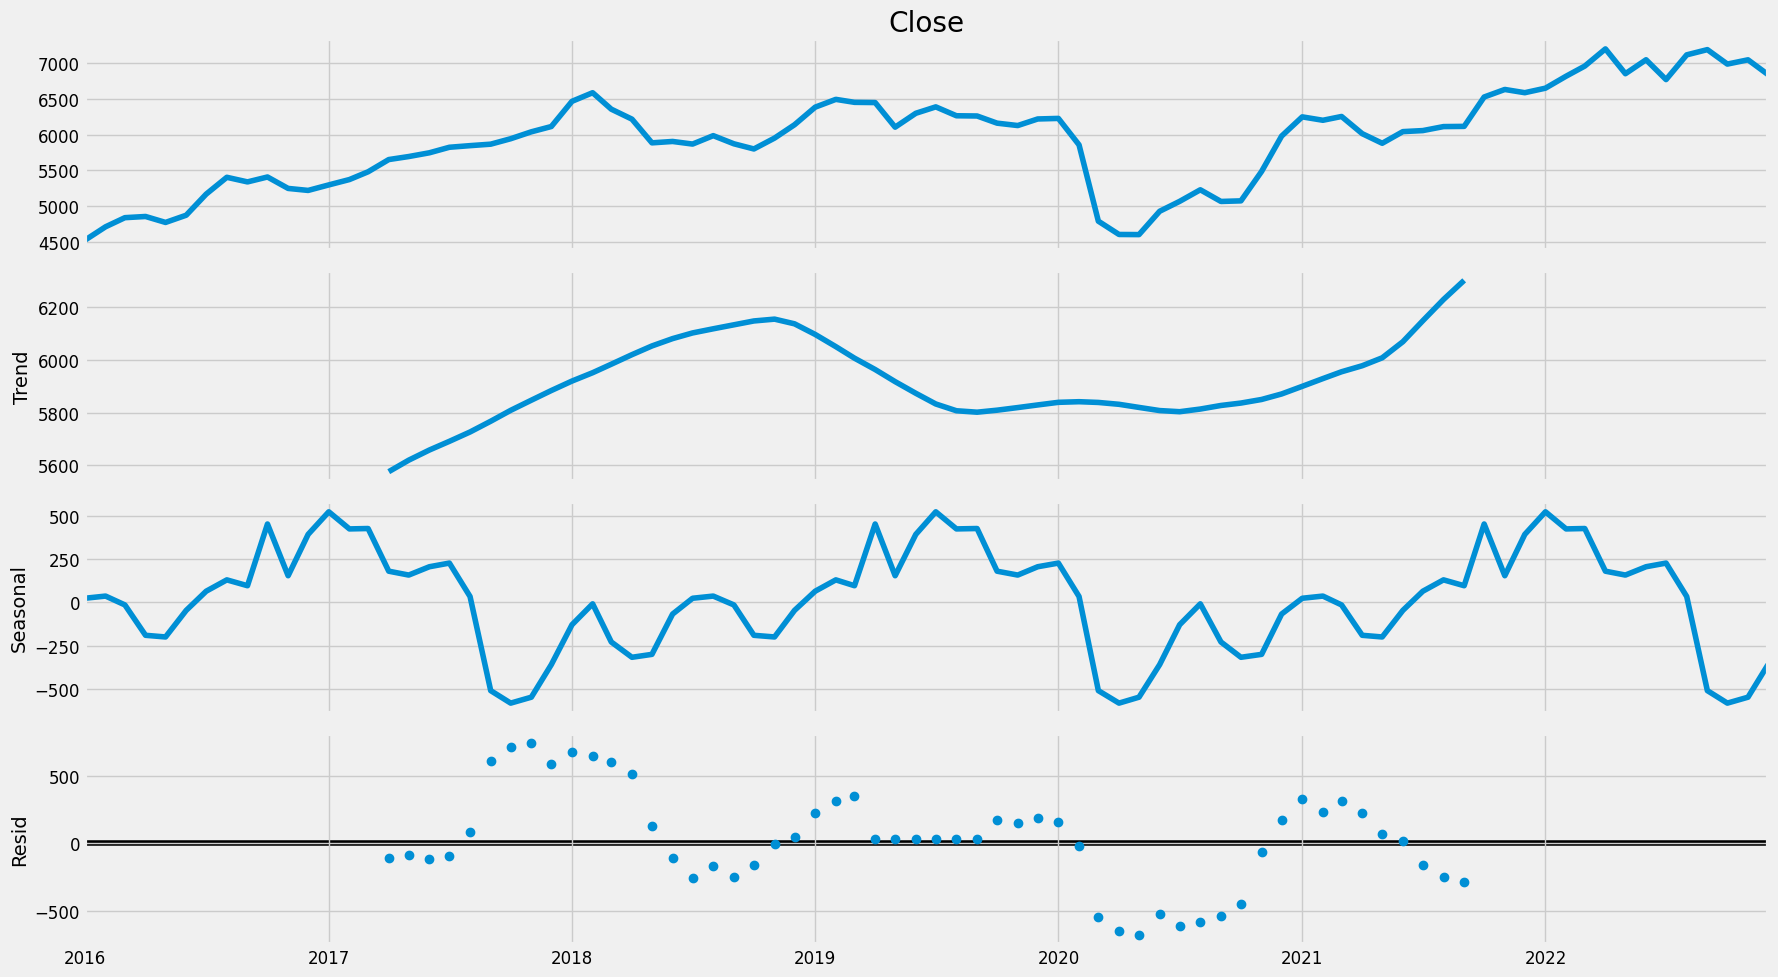

In [15]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 10
decomposition = sm.tsa.seasonal_decompose(y, model='additive',period=30)
fig = decomposition.plot()
plt.show()

Observation:
1) Trend: downward trend followed by the mostly linear upward trend
2) Seasonality: Interestingly, it seems there is seasonality every 2.5-3 years
    a) end of 2017 to 2020 (3+12+12 = 27 months)
    b) early 2020 to mid 2022 (9+12+6 = 27 months)
3) Residuals: the index price is susceptible to random shocks and noise. Of course, this is the stock market.

In [16]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [17]:
# This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find 
# the optimal set of parameters that yields the best performance for our model.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1681.4334855281497
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1396.3700822007268
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1157.646588470395
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:963.7413902611096
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1167.5502364492895
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1156.0175455413996
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:982.1583504883952
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:955.9925861391824
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1605.010309692153
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1360.978978819678
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1065.187926969247
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:880.6050981586604
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1091.061831235953
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1063.6334395805238
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:916.6415392230917
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:879.0498096158792
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1116.0103781043654
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:961.1075978239763
ARIM

c:\Projects\handson\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:977.0278525820421
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:833.2771768990598
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:820.4578630688768
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1114.322336424931
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:960.9585605619153
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:988.3708905639342
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:801.3998745102807
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:973.0674173964517
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:962.0139136829403
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:827.1870062532229
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:802.9939902699689
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1111.794945331912
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:958.2180595422906
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:990.0989361004658
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:803.7136575881959
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:957.7731829462148
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:959.497401211907
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:813.9364313227917
ARIMA(1, 1,

The setting ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:633.959576518351 produce the lowest AIC.
Let's use this parameters

In [18]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2281      0.381      0.599      0.549      -0.519       0.975
ma.L1          0.1155      0.390      0.296      0.767      -0.648       0.879
ma.S.L12      -1.0000      0.154     -6.489      0.000      -1.302      -0.698
sigma2      3.699e+04   4.17e-06   8.88e+09      0.000     3.7e+04     3.7e+04


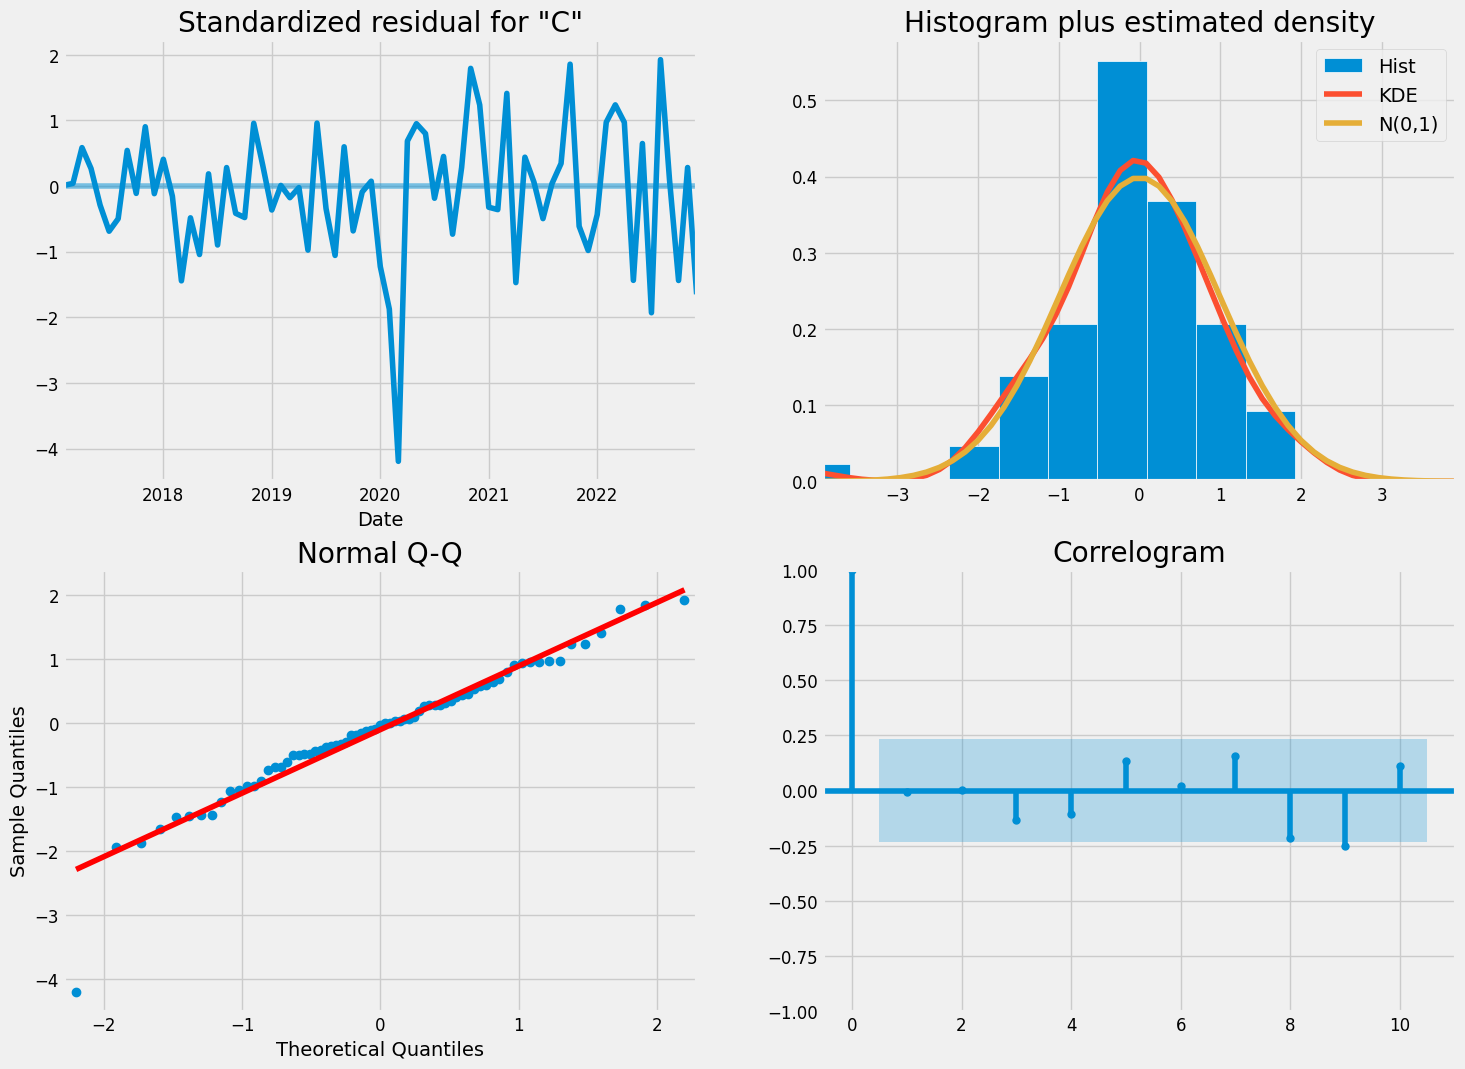

In [19]:
# We should always run model diagnostics to investigate any unusual behavior
results.plot_diagnostics(figsize=(16, 12))
plt.show()

It is not perfect, however, our model diagnostics suggests that the model residuals are near normally distributed.
Points on the Normal QQ plot provide an indication of univariate normality of the dataset. If the data is not normally distributed, the points will deviate from the reference line.

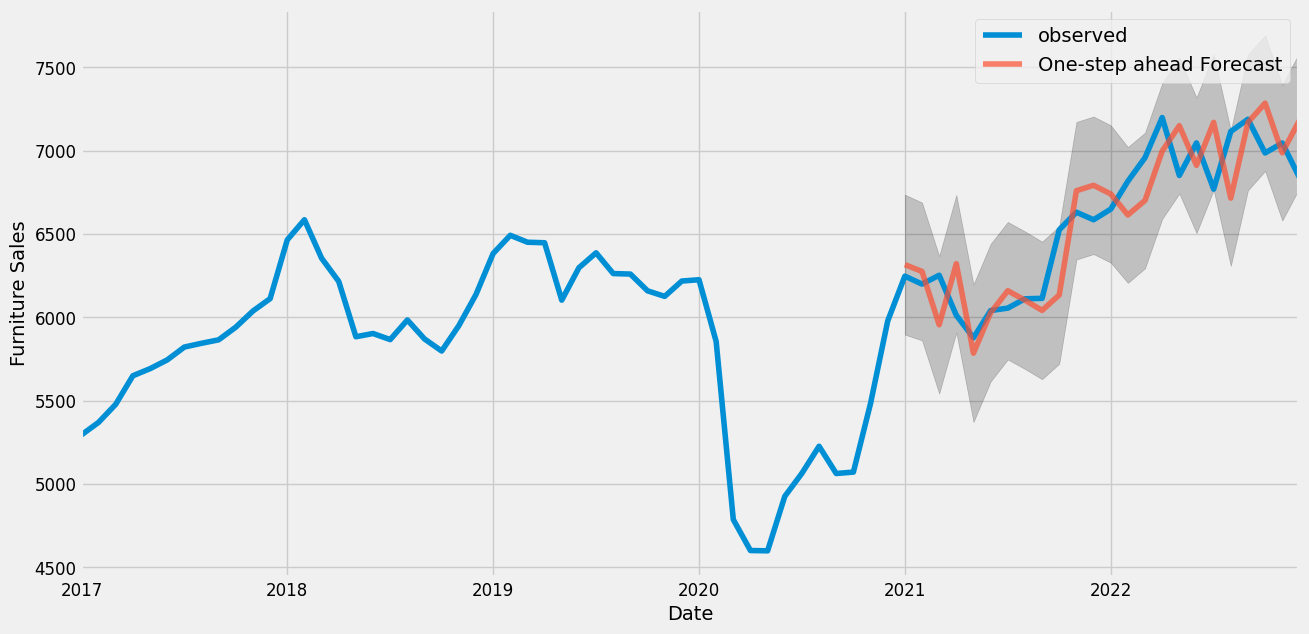

In [20]:
pred = results.get_prediction(start=pd.to_datetime('2021-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year and captured the seasonality toward the end of the year

In [21]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 51071.98


In [22]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 225.99


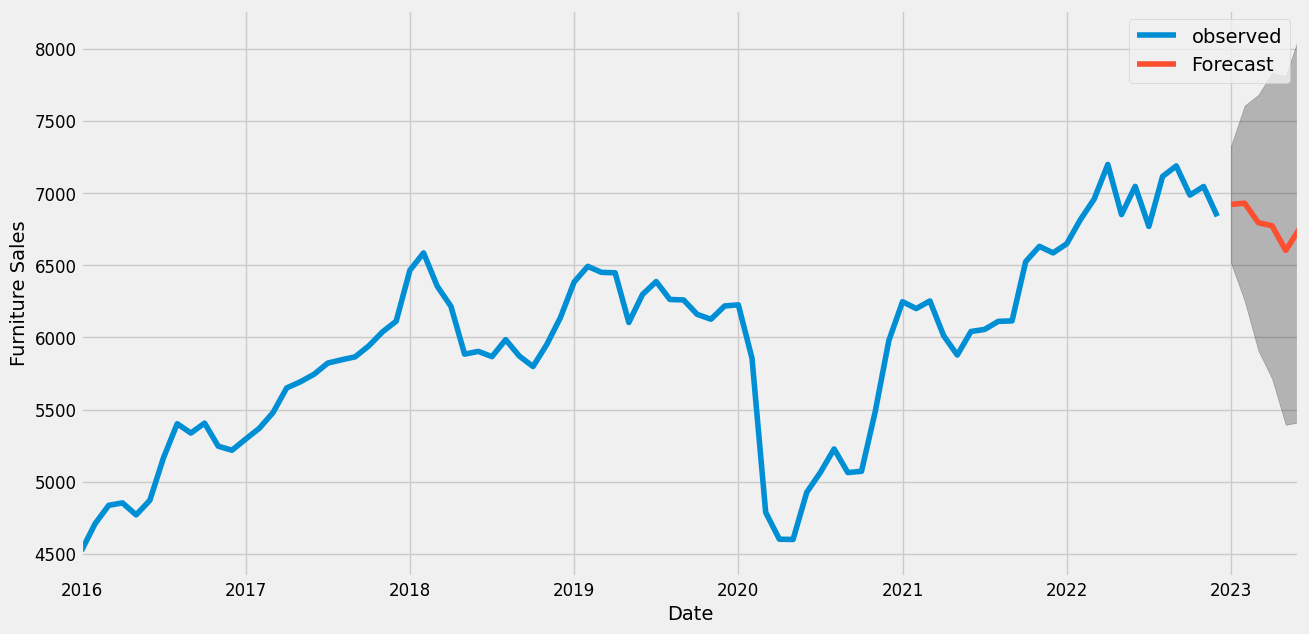

In [23]:
# Producing and visualizing forecasts
pred_uc = results.get_forecast(steps=6)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

Based on this, the earlier part of 2023 will be neither bullish or bearish. It will be in the sideways in trading range between 6500 to 7000.
Let's confirm with the actual.

In [24]:
# I download the actual until mid 2023
dl_start="2017-01-01"
dl_end = "2023-06-30" # 6 months
act = yf.download(symbol,start=dl_start, end=dl_end)

[*********************100%%**********************]  1 of 1 completed


In [25]:
# I will use Adj Close instead of Close. Adj Close incorporated dividen & other corporate actions
act['Close'] = act['Adj Close']
drop_cols = ['Volume', 'Open', 'Low', 'High', 'Adj Close']
act = act.drop(drop_cols,axis=1)
act = act['Close'].resample('MS').mean()

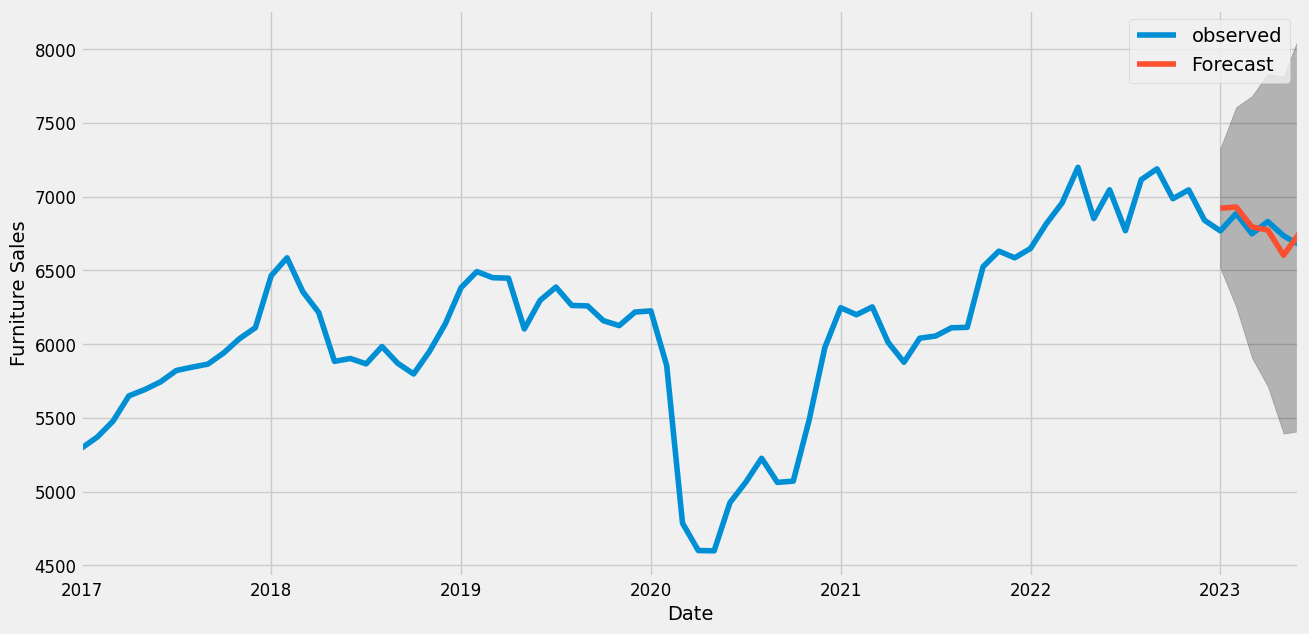

In [26]:
# Producing and visualizing forecasts
#pred_uc = results.get_forecast(steps=10)
#pred_ci = pred_uc.conf_int()
ax = act.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

Eventhough they are not very close but it confirms that the first semester of 2023, the JKSE will trading in sideways/swing in the range 6500 to 7000.
In the future to improve the performance, I will add more predictors/technical indicators.

Reference:
https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

